# Crop de iris para fotos de ojo


## Cargo Librarías

In [ ]:
!git clone https://github.com/domingomery/balu3
!pip install ./balu3

Cloning into 'balu3'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 261 (delta 152), reused 177 (delta 74), pack-reused 0
Receiving objects: 100% (261/261), 68.46 KiB | 1.12 MiB/s, done.
Resolving deltas: 100% (152/152), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./balu3
  Preparing metadata (setup.py) ... done
  Created wheel for balu3: filename=balu3-1.0-py3-none-any.whl size=43704 sha256=6b962f62511b5e61884381e32d6d1307a8147923cd0f6bfbab8d3b778c3d880b
  Stored in directory: /tmp/pip-ephem-wheel-cache-a80uonzh/wheels/9e/f6/a9/3d39da83a3504331129d706f5b04ceb3dbf0ec0f313cdb8fcf
Successfully built balu3


In [ ]:
# General
import numpy as np
import cv2
import os

# Procesamiento de imagenes
from   scipy.ndimage import binary_fill_holes
from   skimage.morphology import disk,dilation

# Visualizacion
import matplotlib.pyplot as plt
from   seaborn import heatmap
from   tqdm.auto import tqdm

# Extraccion/seleccion de caracteristicas, clasificacion, evaluacion
from   balu3.fx.geo    import fourierdes, hugeo, flusser, gupta,basicgeo
from   balu3.fx.chr    import lbp, haralick, gabor, hog
from   balu3.fs.sel    import sfs,clean
from   balu3.ft.norm   import minmax
from   balu3.fs.sel    import jfisher,sfs
from   balu3.io.misc   import num2fixstr, imageload # img    = plt.imread(st)
from   balu3.cl.basics import SplitTrainTest,ClassifierKNN
from   balu3.ft.trans  import pca

# Características extra
import pywt # WAVELET
from skimage.feature import graycomatrix, graycoprops # GLCM Texture Features
# Para descargar ariables
from google.colab import files

## Cargo los datosgraycomatrix

In [ ]:
!wget https://www.dropbox.com/s/s4opefjionbdbab/G00.zip
!wget https://www.dropbox.com/s/zur2wxzcce4qlgf/G01.zip
!unzip -qq G00.zip
!unzip -qq G01.zip 
print('Base de datos G3x4 cargada.')

--2023-06-10 22:36:04--  https://www.dropbox.com/s/s4opefjionbdbab/G00.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/s4opefjionbdbab/G00.zip [following]
--2023-06-10 22:36:05--  https://www.dropbox.com/s/raw/s4opefjionbdbab/G00.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc334d0d42485d3def08fd125467.dl.dropboxusercontent.com/cd/0/inline/B9ttLnlTrr20iLGhHauTjV6yoIeOjyoO-fYh6n0IVbi0Jm0sI9eU5gnO5topQ5JzFUeZjQuC0KVH3S4RdcZdH1YgykGp7Fh3cmTMbOAjSHxNY74kAOYU52QcMl3wcX3ylSVeE03Rig9dair4bkMVF0FkptawZX6wdBne9RMQPr7A3w/file# [following]
--2023-06-10 22:36:05--  https://uc334d0d42485d3def08fd125467.dl.dropboxusercontent.com/cd/0/inline/B9ttLnlTrr20iLGhHauTjV6yoIeOjyoO-fYh6n0IVbi0Jm0sI9eU5gnO5topQ5JzFUeZjQuC0KVH3S4RdcZdH1YgykGp7Fh

Cargo imagen pra probar que funcione

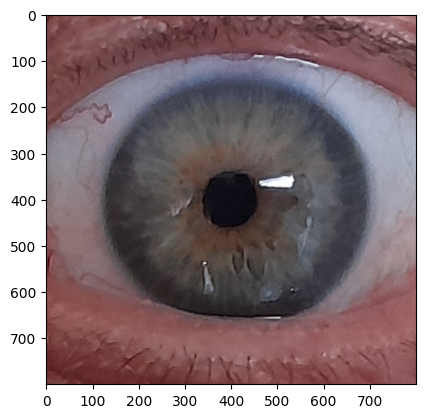

In [ ]:
clase     = 90
num_img   = 10

dig_clase = 3
dig_img   = 3
fpath     = 'G00'
prefix    = 'ID'
imprefix  = fpath + '/' + prefix

img       = imageload(imprefix,clase,dig_clase,num_img,dig_img)

plt.imshow(img)
plt.show()

## Función Crop image 

Guarda las imágenes en una nueva carpeta

In [ ]:
def CropImg(mascara,diametro_circulo,path_crop):

  K      = 90     # número de clases
  N      = 12     # número de imágenes por clase

  # Las imágenes estan en textures/D_xxx_nnn.png, donde xxx es el número de la
  # clase (001, 002, ... 111 en tres dígitos) y nnn es el número de la imagen
  # (001, 002, ... 009 en tres dígitos)
  dig_clase = 3
  dig_img   = 3
  fpath     = 'G00'
  prefix    = 'ID'
  imprefix  = fpath + '/' + prefix

  print('Cargando imagenes y recortando bordes...')
  for j in tqdm(range(K)):            # para cada clase
    for i in range(N):                # para cada imagen de la clase
      # Lectura de la imagen
      clase           = j+1
      num_img         = i+1
      img             = imageload(imprefix,clase,dig_clase,num_img,dig_img)
      alto, ancho     = img.shape[:2]
      bordes_recorte  = alto // 2 - diametro_circulo // 2
      img_crop        = img[bordes_recorte:alto-bordes_recorte,bordes_recorte:ancho-bordes_recorte,:]*np.repeat(mascara[:, :, np.newaxis], 3, axis=2)
      image_path      = os.path.join(path_crop, 'Crop_' + prefix + num2fixstr(clase,dig_clase) + '_' + num2fixstr(num_img,dig_img) + '.png')
      plt.imsave(image_path, img_crop, cmap='gray')



Creo nueva carpeta y llamo a la función

In [ ]:
# Creo una carpeta para almacenar las imágenes recordatas
path_crop = '/content/Crop_G00'
os.makedirs(path_crop, exist_ok=True)

In [ ]:
# Creo máscara
diametro_circulo = 600

centro_x = diametro_circulo // 2
centro_y = diametro_circulo // 2

mascara = np.zeros((diametro_circulo, diametro_circulo))

# Create the circle
for i in range(diametro_circulo):
    for j in range(diametro_circulo):
        if np.sqrt((i - centro_x) ** 2 + (j - centro_y) ** 2) <= diametro_circulo // 2:
            mascara[i, j] = 1

CropImg(mascara,diametro_circulo,path_crop)

Cargando imagenes y extrayendo características...


  0%|          | 0/90 [00:00<?, ?it/s]

Visualizo imágenes 

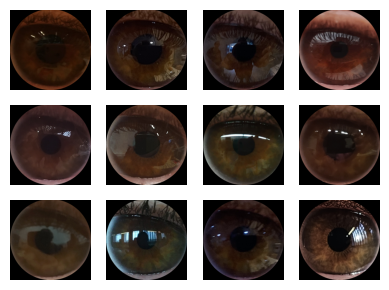

In [ ]:
# Número ID
id=47
img_batch = []

for j in range(12):
  img = imageload('Crop_G00/Crop_ID',id,3,j+1,3)
  img_batch.append(img)

# subplots de 3x4 
fig, axes = plt.subplots(3, 4, figsize=(4, 3))

for i, ax in enumerate(axes.flat):
    ax.imshow(img_batch[i])
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Creo archivo zip con las fotos cropeadas

In [ ]:
import zipfile

In [ ]:
# Specify the folder path and name
folder_path  = '/content/Crop_G00'
folder_name = 'Crop_G00'

# Specify the zip file path and name
zip_file_path = '/content/Crop_G00.zip'

# Create a zip file
with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Iterate over the files in the folder and add them to the zip file
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, arcname=os.path.join(folder_name, file))

print(f"Zip file created: {zip_file_path}")

Zip file created: /content/Crop_G00.zip
